In [1]:
from os import listdir
import cv2
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import VGG16
from keras.layers import Input, Flatten, Dense, Dropout
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-11-09 08:30:14.911661: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 08:30:14.912074: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 08:30:14.914097: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-09 08:30:14.920147: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731141014.930654   30777 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731141014.93

In [ ]:
raw_folder = "data/"
def save_data(raw_folder=raw_folder):

    dest_size = (128, 128)
    print("Bắt đầu xử lý ảnh...")

    pixels = []
    labels = []

    # Lặp qua các folder con trong thư mục raw
    for folder in listdir(raw_folder):
        if folder!='.DS_Store':
            print("Folder=",folder)
            # Lặp qua các file trong từng thư mục chứa các em
            for file in listdir(raw_folder  + folder):
                if file!='.DS_Store':
                    print("File=", file)
                    pixels.append( cv2.resize(cv2.imread(raw_folder  + folder +"/" + file),dsize=dest_size))
                    labels.append( folder)

    pixels = np.array(pixels)
    labels = np.array(labels)#.reshape(-1,1)

    from sklearn.preprocessing import LabelBinarizer
    encoder = LabelBinarizer()
    labels = encoder.fit_transform(labels)
    print(labels)

    file = open('pix.data', 'wb')
    print("1")
    # dump information to that file
    pickle.dump((pixels,labels), file)
    # close the file
    file.close()

    return

save_data()

Bắt đầu xử lý ảnh...
Folder= 010000
File= 010000_44.png
File= 010000_230.png
File= 010000_74.png
File= 010000_191.png
File= 010000_156.png
File= 010000_33.png
File= 010000_232.png
File= 010000_208.png
File= 010000_229.png
File= 010000_102.png
File= 010000_166.png
File= 010000_89.png
File= 010000_223.png
File= 010000_48.png
File= 010000_62.png
File= 010000_53.png
File= 010000_114.png
File= 010000_150.png
File= 010000_159.png
File= 010000_130.png
File= 010000_165.png
File= 010000_83.png
File= 010000_162.png
File= 010000_19.png
File= 010000_152.png
File= 010000_21.png
File= 010000_58.png
File= 010000_99.png
File= 010000_75.png
File= 010000_237.png
File= 010000_115.png
File= 010000_233.png
File= 010000_28.png
File= 010000_109.png
File= 010000_182.png
File= 010000_144.png
File= 010000_209.png
File= 010000_202.png
File= 010000_172.png
File= 010000_206.png
File= 010000_151.png
File= 010000_126.png
File= 010000_87.png
File= 010000_110.png
File= 010000_240.png
File= 010000_79.png
File= 010000_2

In [4]:
def load_data():
    file = open('pix.data', 'rb')

    # dump information to that file
    (pixels, labels) = pickle.load(file)

    # close the file
    file.close()

    print(pixels.shape)
    print(labels.shape)


    return pixels, labels

#save_data()
X,y = load_data()
#random.shuffle(X)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=100)

print(X_train.shape)
print(y_train.shape)

(1558, 128, 128, 3)
(1558, 7)
(1246, 128, 128, 3)
(1246, 7)


In [ ]:
def get_model():
    model_vgg16_conv = VGG16(weights='imagenet', include_top=False)

    # Dong bang cac layer
    for layer in model_vgg16_conv.layers:
        layer.trainable = True

    # Tao model
    input = Input(shape=(128, 128, 3), name='image_input')
    output_vgg16_conv = model_vgg16_conv(input)

    # Them cac layer FC va Dropout
    x = Flatten(name='flatten')(output_vgg16_conv)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dropout(0.5)(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dropout(0.5)(x)
    x = Dense(7, activation='softmax', name='predictions')(x)

    # Compile
    my_model = Model(inputs=input, outputs=x)
    my_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return my_model

vggmodel = get_model()

filepath = "weights-{epoch:02d}-{val_accuracy:.2f}.weights.h5"
checkpoint = ModelCheckpoint(
    filepath=filepath,
    save_weights_only=True,  # Only saves the weights
    monitor="val_accuracy",
    mode="max",
    save_best_only=True
)

callbacks_list = [checkpoint]


2024-11-09 08:30:25.678999: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [6]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20, zoom_range=0.1,
    rescale=1./255,
	width_shift_range=0.1,
    height_shift_range=0.1,
	horizontal_flip=True,
    brightness_range=[0.2,1.5], fill_mode="nearest")

aug_val = ImageDataGenerator(rescale=1./255)

In [7]:

vgghist = vggmodel.fit(
    aug.flow(X_train, y_train, batch_size=64),
    epochs=50,
    validation_data=aug.flow(X_test, y_test, batch_size=64),
    callbacks=callbacks_list
)

vggmodel.save("vggmodel.h5")

/home/triet/AI/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.1542 - loss: 9.3931 - val_accuracy: 0.1699 - val_loss: 1.9406
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - accuracy: 0.1512 - loss: 1.9877 - val_accuracy: 0.1699 - val_loss: 1.9300
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 104s 5s/step - accuracy: 0.1701 - loss: 1.9321 - val_accuracy: 0.1699 - val_loss: 1.9192
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.1415 - loss: 1.9320 - val_accuracy: 0.1571 - val_loss: 1.9145
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 99s 5s/step - accuracy: 0.1541 - loss: 1.9378 - val_accuracy: 0.1571 - val_loss: 1.9137
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step - accuracy: 0.1542 - loss: 1.9285 - val_accuracy: 0.1635 - val_loss: 1.9140
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 98s 5s/step - accuracy: 0.1659 - loss: 1.9253 - val_accuracy: 0.1699 - val_loss: 1.9157
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step - accuracy: 0.1690 - loss: 1.9402 - val_accuracy: 0.1571 - val

In [10]:
def plot_model_history(model_history, acc='accuracy', val_acc='val_accuracy'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plotting accuracy
    axs[0].plot(range(1, len(model_history.history[acc]) + 1), model_history.history[acc])
    axs[0].plot(range(1, len(model_history.history[val_acc]) + 1), model_history.history[val_acc])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    
    # Fix the tick positions to be an array or list
    ticks = np.arange(1, len(model_history.history[acc]) + 1, len(model_history.history[acc]) // 10)
    axs[0].set_xticks(ticks)
    axs[0].legend(['train', 'val'], loc='best')
    
    # Plotting loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    
    # Fix the tick positions for loss
    ticks_loss = np.arange(1, len(model_history.history['loss']) + 1, len(model_history.history['loss']) // 10)
    axs[1].set_xticks(ticks_loss)
    axs[1].legend(['train', 'val'], loc='best')
    
    # Save the plot
    plt.savefig('roc.png')

    



In [11]:
from keras.models import load_model

# Load the model from the .h5 file
model = load_model('vggmodel.h5')

# Save the model in Keras format
model.save('data/model.keras')  # Use the .keras extension


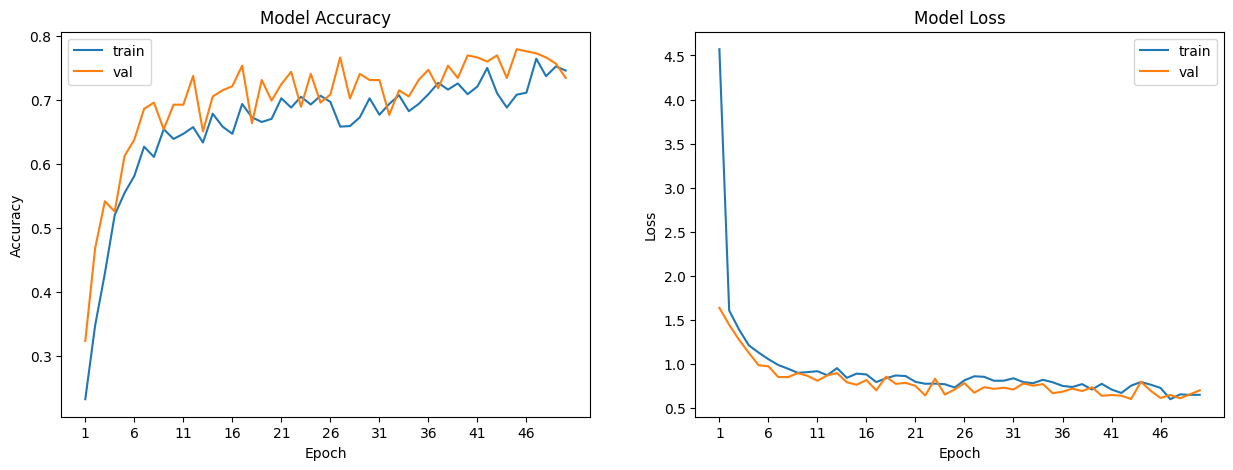

In [53]:
plot_model_history(vgghist)